In [ ]:
# Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

#from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler 

import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## REDUCED DATASET (only has 2019 data, top 50 airports and 30 new features)


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
# WHOLE DATA THAT HAS 100 AIRPORTS
#data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/data_with_weather.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
# REDUCED DATASET WITH TOP 5 AIRLINES BASED ON NUMBER OF DELAYS
#data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/top5.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
# REDUCED DATASET WITH TOP 50 AIRPORTS
#data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/top5b.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
# REDUCED DATASET WITH TOP 50 AIRPORTS AND LATEST FEATURES
#data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final_dataset_small.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
#REDUCED DATASET WITH TOP 50 AIRPORTS AND LATEST FEATURES
#data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/final_dataset_large.csv').drop(['Unnamed: 0'],axis=1)

In [ ]:
#VALIDATION USING FLIGHT_TEST REDUCED DATASET WITH TOP 50 AIRPORTS AND LATEST FEATURES
data_incl_weather = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/flights_test.csv').drop(['Unnamed: 0'],axis=1)

# DATA PREPARATION

In [ ]:
data_incl_weather.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,weather_origin,weather_dest,std_crs_dep_time,std_crs_arr_time,airline_avg_delay_time,airline_total_n_delays,airline_delay_risk,op_avg_dep_delay,avg_occupancy,airline_avg_rec_time,airline_recovery_score,airline_distance_delay_ratio,airline_distance_airtime_ratio,airline_actual_crs_ratio,avg_3h_taxi_out,avg_3h_taxi_in,origin_avg_delay,dest_avg_delay,avg_delay_time_arrival,day-night
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363,Clear,Partly cloudy,1800,1800,19.943003,31493,0,19.908615,0.740608,-0.034389,0,130.457102,6.721719,1.001628,13.177778,8.351706,19.35512,29.632035,24.740114,0
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363,Sunny,Partly cloudy,900,1200,19.943003,31493,0,19.908615,0.740608,-0.034389,0,130.457102,6.721719,1.001628,16.382353,10.535144,19.35512,29.632035,21.768203,1


In [ ]:
#data_incl_weather[['weather_dest','arr_delay']].groupby('weather_dest').agg(arr_delay_count=('arr_delay','count'),
#                                                                            arr_delay_mean=('arr_delay','mean')).sort_values(by='arr_delay_count',ascending=False)

In [ ]:
## Function to create Bins to reduce weather from 45 variables to 5 (Cloudy/Sunny/Rainiy/Snowy/Other)
def weather_bins (x):
    
    if 'loudy' in x or 'Overcast' in x:
        bin = 'Overcast'
    elif 'unny' in x or 'Clear' in x:
        bin = 'Sunny'
    elif 'rain' in x or 'drizzle' in x:
        bin = 'Rainy'
    elif 'snow' in x:
        bin = 'Snowy'
    else:
        bin = 'Other' 
    return bin

In [ ]:
## Mapping Weather to Bins (Cloudy/Sunny/Rainiy/Snowy/Other)
data_incl_weather['weather_dest_bin']= data_incl_weather['weather_dest'].apply(weather_bins)
data_incl_weather['weather_origin_bin']= data_incl_weather['weather_origin'].apply(weather_bins)

In [ ]:
#data_incl_weather[['weather_dest_bin','arr_delay']].groupby('weather_dest_bin').agg(arr_delay_count=('arr_delay','count'),
#                                                                            arr_delay_mean=('arr_delay','mean')).sort_values(by='arr_delay_count',ascending=False)

In [ ]:
data_incl_weather.head(2)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,weather_origin,weather_dest,std_crs_dep_time,std_crs_arr_time,airline_avg_delay_time,airline_total_n_delays,airline_delay_risk,op_avg_dep_delay,avg_occupancy,airline_avg_rec_time,airline_recovery_score,airline_distance_delay_ratio,airline_distance_airtime_ratio,airline_actual_crs_ratio,avg_3h_taxi_out,avg_3h_taxi_in,origin_avg_delay,dest_avg_delay,avg_delay_time_arrival,day-night,weather_dest_bin,weather_origin_bin
0,2020-01-01,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363,Clear,Partly cloudy,1800,1800,19.943003,31493,0,19.908615,0.740608,-0.034389,0,130.457102,6.721719,1.001628,13.177778,8.351706,19.35512,29.632035,24.740114,0,Overcast,Sunny
1,2020-01-01,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363,Sunny,Partly cloudy,900,1200,19.943003,31493,0,19.908615,0.740608,-0.034389,0,130.457102,6.721719,1.001628,16.382353,10.535144,19.35512,29.632035,21.768203,1,Overcast,Sunny


In [ ]:
#Saving Target Variable and 'fl_date'
data_incl_weather_dates = data_incl_weather['fl_date']

#UNCOMMENT IF NOT USING FLIGHT_TEST
#data_incl_weather_arr_delay = data_incl_weather['arr_delay']

# SUBMISSION FILE PREPARATION

In [81]:
submission_file_columns= data_incl_weather[['fl_date','mkt_carrier','mkt_carrier_fl_num','origin','dest']]
submission_file_columns.to_csv('submission_columns.csv',index=False)
submission_file_columns.shape

(119591, 5)

In [73]:
data_incl_weather.columns

Index(['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier', 'tail_num',
       'op_carrier_fl_num', 'origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name', 'crs_dep_time',
       'crs_arr_time', 'dup', 'crs_elapsed_time', 'flights', 'distance',
       'weather_origin', 'weather_dest', 'std_crs_dep_time',
       'std_crs_arr_time', 'airline_avg_delay_time', 'airline_total_n_delays',
       'airline_delay_risk', 'op_avg_dep_delay', 'avg_occupancy',
       'airline_avg_rec_time', 'airline_recovery_score',
       'airline_distance_delay_ratio', 'airline_distance_airtime_ratio',
       'airline_actual_crs_ratio', 'avg_3h_taxi_out', 'avg_3h_taxi_in',
       'origin_avg_delay', 'dest_avg_delay', 'avg_delay_time_arrival',
       'day-night', 'weather_dest_bin', 'weather_origin_bin'],
      dtype='object')

In [34]:
#PREPARING X_test from Validation Dataset Flight_Test

#WHEN USING THE REDUCED DATASET WITH TOP 50 AIRPORTS BASED ON NUMBER OF DELAYS
data_X_from_Flight_Test = data_incl_weather.drop(['fl_date','mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'tail_num','op_carrier_fl_num', 'origin_airport_id', 'origin_city_name','dest_city_name',
       'dest_airport_id', 'crs_elapsed_time','flights','weather_origin', 'weather_dest','dup'],axis=1)

data_X_from_Flight_Test = data_X_from_Flight_Test[['op_unique_carrier', 'origin', 'dest', 'crs_dep_time', 'crs_arr_time',
       'distance', 'std_crs_dep_time', 'std_crs_arr_time',
       'airline_avg_delay_time', 'airline_total_n_delays',
       'airline_delay_risk', 'avg_3h_taxi_out', 'avg_3h_taxi_in',
       'op_avg_dep_delay', 'avg_occupancy', 'day-night',
       'airline_avg_rec_time', 'airline_recovery_score', 'origin_avg_delay',
       'dest_avg_delay', 'avg_delay_time_arrival',
       'airline_distance_delay_ratio', 'airline_distance_airtime_ratio',
       'airline_actual_crs_ratio', 'weather_dest_bin', 'weather_origin_bin']]



In [35]:
data_X_from_Flight_Test.dtypes

op_unique_carrier                  object
origin                             object
dest                               object
crs_dep_time                        int64
crs_arr_time                        int64
distance                            int64
std_crs_dep_time                    int64
std_crs_arr_time                    int64
airline_avg_delay_time            float64
airline_total_n_delays              int64
airline_delay_risk                  int64
avg_3h_taxi_out                   float64
avg_3h_taxi_in                    float64
op_avg_dep_delay                  float64
avg_occupancy                     float64
day-night                           int64
airline_avg_rec_time              float64
airline_recovery_score              int64
origin_avg_delay                  float64
dest_avg_delay                    float64
avg_delay_time_arrival            float64
airline_distance_delay_ratio      float64
airline_distance_airtime_ratio    float64
airline_actual_crs_ratio          

In [36]:
#WHEN USING THE WHOLE DATASET WITH 100 AIRPORTS
#data_incl_weather_01 = data_incl_weather.drop(['fl_date','mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
#      'mkt_carrier_fl_num', 'tail_num',
#       'op_carrier_fl_num', 'origin_airport_id', 'origin_city_name',
#       'dest_airport_id', 'dest_city_name', 'dep_time',
#       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'arr_time', 'cancelled', 'diverted', 'dup',
#       'crs_elapsed_time','actual_elapsed_time', 'air_time', 'flights','weather_origin', 'weather_dest','std_crs_dep_time',
#       'std_crs_arr_time',
#       ],axis=1)

#WHEN USING THE REDUCED DATASET WITH TOP 50 AIRPORTS BASED ON NUMBER OF DELAYS
#data_incl_weather_01 = data_incl_weather.drop(['fl_date',
#       'origin_city_name','dest_city_name','dep_time',
#       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'crs_elapsed_time','actual_elapsed_time', 'arr_time',
#       'air_time', 'flights','weather_origin', 'weather_dest'],axis=1)
#data_incl_weather_01.head()


In [37]:
data_incl_weather_01 = data_X_from_Flight_Test.copy()

In [39]:
#data_incl_weather_01.dtypes

In [41]:

#Creating Dummy Variables
dummy_carrier = pd.get_dummies(data_incl_weather_01['op_unique_carrier'],prefix='carr_',drop_first=False)
dummy_origin = pd.get_dummies(data_incl_weather_01['origin'],prefix='orig_',drop_first=False)
dummy_dest = pd.get_dummies(data_incl_weather_01['dest'],prefix='dest_',drop_first=False)
dummy_weather_dest = pd.get_dummies(data_incl_weather_01['weather_dest_bin'],prefix='dest_',drop_first=False)
dummy_weather_origin = pd.get_dummies(data_incl_weather_01['weather_origin_bin'],prefix='orig_',drop_first=False)


In [42]:
#data_incl_weather_01['weather_origin_bin']

In [43]:
#Dropping Object Variables which will be replaced by dummy variables in next cell
to_drop = ['op_unique_carrier','origin','dest','weather_dest_bin','weather_origin_bin']
data_incl_weather_01.drop(to_drop,axis=1,inplace=True)

In [54]:
#Data_crude after dropping useless columns and getting dummies for carrier, origin and dest 226ish new variables
data_incl_weather_02 = pd.concat([data_incl_weather_01,dummy_carrier,dummy_origin,dummy_dest,dummy_weather_dest,dummy_weather_origin],axis=1)
#data_X = data_incl_weather_02.drop(['arr_delay'],axis=1)
data_X = data_incl_weather_02.copy()
#data_X.dtypes

# ADDING NEW ENGINEERED FEATURE (ALREADY IN PLACE IN THE REDUCED DATASET)



In [55]:
a_file = open('/content/drive/MyDrive/Colab Notebooks/Data/airlines_data.pkl', "rb")
data_airlines = pickle.load(a_file)

top5_new_var = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/top5a.csv')

In [56]:
data_airlines.head(2)

,airline_delay_risk,airline_avg_delay_time,airline_total_n_delays
0,1,20.566879,4396
1,1,20.566879,4396


In [57]:
#data_X = pd.concat([data_X, data_airlines],axis=1)

In [58]:
#data_X = pd.concat([data_X, top5_new_var['op_avg_dep_delay']],axis=1)

In [59]:
#data_X.head(2)

# SCALING (SOME VARIABLES)

In [61]:
#SCALING data_X using MinMaxScaler
#Scaling only columns that have values > 1, in this case crs_dep_time and crs_arr_time and "distance". will be dummy (SHORT/MEDIUM/LONG haul)

to_scale = ['crs_dep_time','crs_arr_time','std_crs_dep_time','std_crs_arr_time',
            'airline_avg_delay_time', 'airline_total_n_delays','avg_3h_taxi_out',
            'avg_3h_taxi_in','op_avg_dep_delay','airline_avg_rec_time',
            'origin_avg_delay','dest_avg_delay','avg_delay_time_arrival','airline_distance_delay_ratio',
            'airline_distance_airtime_ratio','airline_actual_crs_ratio']



mms = MinMaxScaler()
scaled = mms.fit_transform(data_X[to_scale])
scaled = pd.DataFrame(scaled,columns=to_scale)
for col in scaled:
  data_X[col] = scaled[col]
#data_X

In [ ]:
#data_X = data_X.drop(['airline_total_n_delays'],axis=1)

In [62]:
data_X.head()

,crs_dep_time,crs_arr_time,distance,std_crs_dep_time,std_crs_arr_time,airline_avg_delay_time,airline_total_n_delays,airline_delay_risk,avg_3h_taxi_out,avg_3h_taxi_in,op_avg_dep_delay,avg_occupancy,day-night,airline_avg_rec_time,airline_recovery_score,origin_avg_delay,dest_avg_delay,avg_delay_time_arrival,airline_distance_delay_ratio,airline_distance_airtime_ratio,airline_actual_crs_ratio,carr__9E,carr__AA,carr__AS,carr__AX,carr__B6,carr__C5,carr__CP,carr__DL,carr__EV,carr__F9,carr__G4,carr__G7,carr__HA,carr__MQ,carr__NK,carr__OH,carr__OO,carr__PT,carr__QX,...,dest__PHL,dest__PHX,dest__PIT,dest__PSP,dest__PVD,dest__RDU,dest__RIC,dest__RNO,dest__ROC,dest__RSW,dest__SAN,dest__SAT,dest__SAV,dest__SDF,dest__SEA,dest__SFB,dest__SFO,dest__SGF,dest__SJC,dest__SJU,dest__SLC,dest__SMF,dest__SNA,dest__STL,dest__SYR,dest__TPA,dest__TUL,dest__TUS,dest__TYS,dest__XNA,dest__Other,dest__Overcast,dest__Rainy,dest__Snowy,dest__Sunny,orig__Other,orig__Overcast,orig__Rainy,orig__Snowy,orig__Sunny
0,0.767077,0.810338,363,0.857143,0.857143,0.282321,1.0,0,0.164208,0.332613,0.598251,0.740608,0,1.0,0,0.179006,0.761763,0.927313,0.495082,0.724935,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,0.487060,0.549812,363,0.428571,0.571429,0.282321,1.0,0,0.249387,0.460359,0.598251,0.740608,1,1.0,0,0.179006,0.761763,0.556499,0.495082,0.724935,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,0.856173,0.887453,333,0.857143,1.000000,0.282321,1.0,0,0.164208,0.217443,0.598251,0.740608,0,1.0,0,0.179006,0.287721,1.000000,0.495082,0.724935,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,0.567671,0.606086,333,0.571429,0.571429,0.282321,1.0,0,0.178844,0.153834,0.598251,0.740608,1,1.0,0,0.179006,0.287721,0.556499,0.495082,0.724935,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,0.387357,0.431013,333,0.428571,0.428571,0.282321,1.0,0,0.249387,0.183152,0.598251,0.740608,1,1.0,0,0.179006,0.287721,0.285884,0.495082,0.724935,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


In [64]:
data_X.shape

(119591, 255)

# BINING OF DISTANCE IN SHORT/MEDIUM/LONG

In [65]:
## Function to create Bins for the Distance Variable
def distance_bins (x):
    
    if x < 800:
        bin = 'Short'
    elif x <= 2200:
        bin = 'Medium'
    else:
        bin = 'Long' 
    return bin

In [66]:
#Binning Distance Variable 
data_X['haul'] = data_X['distance'].apply(distance_bins)

In [67]:
#Creating Dummy Variable for Haul
dummy_haul = pd.get_dummies(data_X['haul'],prefix='',drop_first=False)

In [68]:
# Adding dummies for haul type (distance)
data_X = pd.concat([data_X,dummy_haul],axis=1)

In [69]:
data_X = data_X.drop(['distance','haul'],axis=1)

In [79]:
data_X.shape

(119591, 257)

In [78]:
data_X.to_csv('prepared_flight_test.csv',index=False)

# SCALING ALL VARIABLES INCLUDING DUMMIES (NOT USED HERE)

In [ ]:
#SCALING data_X using MinMaxScaler
#Scaling only columns that have values > 1, in this case crs_dep_time and crs_arr_time and "distance". will be dummy (SHORT/MEDIUM/LONG haul)

to_scale = ['crs_dep_time','crs_arr_time','std_crs_dep_time','std_crs_arr_time',
            'airline_avg_delay_time', 'airline_total_n_delays','avg_3h_taxi_out',
            'avg_3h_taxi_in','op_avg_dep_delay','airline_avg_rec_time',
            'origin_avg_delay','dest_avg_delay','avg_delay_time_arrival','airline_distance_delay_ratio',
            'airline_distance_airtime_ratio','airline_actual_crs_ratio']



mms = MinMaxScaler()
#scaled = mms.fit_transform(data_X[to_scale])
#scaled = pd.DataFrame(scaled,columns=to_scale)
#for col in scaled:
#  data_X[col] = scaled[col]

scaled = mms.fit_transform(data_X)
data_X = pd.DataFrame(scaled,columns=data_X.columns)
data_X

,crs_dep_time,crs_arr_time,std_crs_dep_time,std_crs_arr_time,airline_avg_delay_time,airline_total_n_delays,airline_delay_risk,avg_3h_taxi_out,avg_3h_taxi_in,op_avg_dep_delay,avg_occupancy,day-night,airline_avg_rec_time,airline_recovery_score,origin_avg_delay,dest_avg_delay,avg_delay_time_arrival,airline_distance_delay_ratio,airline_distance_airtime_ratio,airline_actual_crs_ratio,carr__AA,carr__DL,carr__OO,carr__UA,carr__WN,orig__ATL,orig__AUS,orig__BNA,orig__BOS,orig__BWI,orig__CLE,orig__CLT,orig__CMH,orig__CVG,orig__DAL,orig__DCA,orig__DEN,orig__DFW,orig__DTW,orig__EWR,...,dest__LAX,dest__LGA,dest__MCI,dest__MCO,dest__MDW,dest__MIA,dest__MKE,dest__MSP,dest__MSY,dest__OAK,dest__ORD,dest__PDX,dest__PHL,dest__PHX,dest__PIT,dest__RDU,dest__RSW,dest__SAN,dest__SAT,dest__SEA,dest__SFO,dest__SJC,dest__SLC,dest__SMF,dest__SNA,dest__STL,dest__TPA,dest__Other,dest__Overcast,dest__Rainy,dest__Snowy,dest__Sunny,orig__Other,orig__Overcast,orig__Rainy,orig__Snowy,orig__Sunny,_Long,_Medium,_Short
0,0.806794,0.822307,0.857143,0.857143,1.000000,0.000000,1.0,0.789349,0.428998,1.0,0.000000,0.0,0.000000,1.0,0.739598,0.600453,0.927313,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.682803,0.777354,0.714286,0.857143,1.000000,0.000000,1.0,0.623588,0.170697,1.0,0.000000,1.0,0.000000,1.0,0.845210,0.377713,0.927313,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.687049,0.730280,0.714286,0.714286,1.000000,0.000000,1.0,0.526218,0.315779,1.0,0.000000,1.0,0.000000,1.0,0.618673,0.600453,0.745577,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.637792,0.659881,0.714286,0.714286,1.000000,0.000000,1.0,0.623588,0.107977,1.0,0.000000,1.0,0.000000,1.0,0.845210,0.425929,0.745577,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.781741,0.821883,0.857143,0.857143,1.000000,0.000000,1.0,0.642859,0.137753,1.0,0.000000,0.0,0.000000,1.0,0.845210,0.425929,0.927313,0.000000,0.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75800,0.738004,0.896098,0.714286,1.000000,0.085226,0.669761,0.5,0.334790,0.310739,0.0,0.540175,1.0,0.116941,0.5,0.497861,0.600453,1.000000,0.738234,0.603786,0.699589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
75801,0.639066,0.698897,0.714286,0.714286,0.085226,0.669761,0.5,0.623588,0.117607,0.0,0.540175,1.0,0.116941,0.5,0.845210,0.299377,0.745577,0.738234,0.603786,0.699589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

# BINNING OF THE TARGET VARIABLE (FROM HERE NOTHING WAS USED)

In [ ]:
## Function to create Bins for the Target Variable
def delay_bins (x):
    
    #float(x)
    if x < 0:
        bin = 0
    elif x <= 10:
        bin = 1
    elif x <= 20:
        bin = 2
    elif x <= 30:
        bin = 3
    else:
        bin = 4 
    #else:
    #    bin = 3 
    return bin

In [ ]:
#Binning Target Variable 
data_weather_delay = pd.DataFrame(data_incl_weather_arr_delay)
data_weather_delay['arr_delay_bins']= data_weather_delay['arr_delay'].apply(delay_bins)
data_y = data_weather_delay['arr_delay_bins']
#data_y

In [ ]:
# Checking Data Balance

In [ ]:
data_y_raw = pd.DataFrame(data_y)
data_y_raw['arr_delay_bins'].value_counts()

1    31927
4    18236
2    16435
3     9207
Name: arr_delay_bins, dtype: int64

In [ ]:
data_X.head(2)

,crs_dep_time,crs_arr_time,std_crs_dep_time,std_crs_arr_time,airline_avg_delay_time,airline_total_n_delays,airline_delay_risk,avg_3h_taxi_out,avg_3h_taxi_in,op_avg_dep_delay,avg_occupancy,day-night,airline_avg_rec_time,airline_recovery_score,origin_avg_delay,dest_avg_delay,avg_delay_time_arrival,airline_distance_delay_ratio,airline_distance_airtime_ratio,airline_actual_crs_ratio,carr__AA,carr__DL,carr__OO,carr__UA,carr__WN,orig__ATL,orig__AUS,orig__BNA,orig__BOS,orig__BWI,orig__CLE,orig__CLT,orig__CMH,orig__CVG,orig__DAL,orig__DCA,orig__DEN,orig__DFW,orig__DTW,orig__EWR,...,dest__LAX,dest__LGA,dest__MCI,dest__MCO,dest__MDW,dest__MIA,dest__MKE,dest__MSP,dest__MSY,dest__OAK,dest__ORD,dest__PDX,dest__PHL,dest__PHX,dest__PIT,dest__RDU,dest__RSW,dest__SAN,dest__SAT,dest__SEA,dest__SFO,dest__SJC,dest__SLC,dest__SMF,dest__SNA,dest__STL,dest__TPA,dest__Other,dest__Overcast,dest__Rainy,dest__Snowy,dest__Sunny,orig__Other,orig__Overcast,orig__Rainy,orig__Snowy,orig__Sunny,_Long,_Medium,_Short
0,0.806794,0.822307,0.857143,0.857143,1.0,0.0,1.0,0.789349,0.428998,1.0,0.0,0.0,0.0,1.0,0.739598,0.600453,0.927313,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.682803,0.777354,0.714286,0.857143,1.0,0.0,1.0,0.623588,0.170697,1.0,0.0,1.0,0.0,1.0,0.845210,0.377713,0.927313,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


# PCA

In [ ]:
n_components = 60
pca = PCA(n_components=n_components)
components = pca.fit_transform(data_X)
#components

In [ ]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

# SPLITTING (replace "components" by "data_X" if not running PCA)

In [ ]:
#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, shuffle=True, train_size=0.8, random_state = 42)

# LOGISTIC REGRESSION (No Final Model - Only Used During Baseline Model Identification)

In [ ]:
# Using SKLEARN LOGISTICREGRESSION
param_grid = {#'penalty' : ['l1','l2'],
              #'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
              'max_iter': [500]}

model = LogisticRegression()
k_folds = 5

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=k_folds, verbose=1, n_jobs=-1) # verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [ ]:
best_model = grid_result.best_estimator_

In [ ]:
y_pred = best_model.predict(X_test)

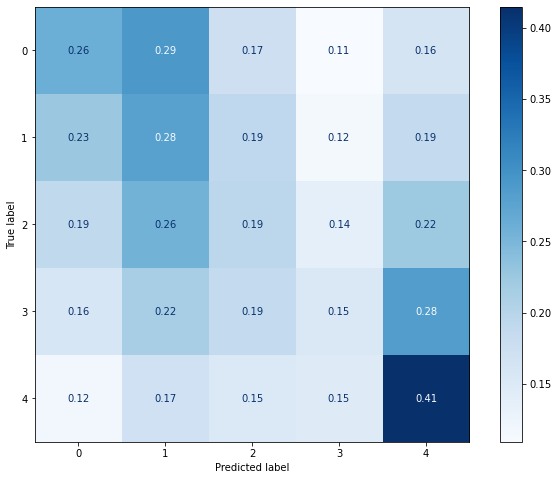

In [ ]:
#PREPARING CONFUSSION MATRIX
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Plot confusion matrix
classifier = best_model
class_names = y_test.unique().sort()
plot_confusion_matrix(classifier, X_test, y_test,
                      display_labels=class_names, cmap=plt.cm.Blues, normalize='true')
plt.grid(False)
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.25759615384615386

In [ ]:
target_names = ['class 1', 'class 2','class 3', 'class 4']
classification_report(y_test, y_pred,target_names=target_names)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n     class 1       0.43      0.84      0.57     12647\n     class 2       0.50      0.00      0.00      6664\n     class 3       0.00      0.00      0.00      3817\n     class 4       0.36      0.29      0.32      8072\n\n    accuracy                           0.42     31200\n   macro avg       0.32      0.28      0.22     31200\nweighted avg       0.37      0.42      0.31     31200\n'

# Random Forest Classifier Baseline (No Final Model - Only Used During Baseline Model Identification)

In [ ]:
clf=RandomForestClassifier()

#max_depth trial [7,8] Final: 7
#n_estimators': [10, 100,200], Final: 100
param_grid = { 
    #'n_estimators': [500],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [7]
    #'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
rfc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
model_rfc = rfc_grid.best_estimator_  # Sklearn automatically retrains the model on the whole 
                                      # training set following cross-validation using the best hyperparameters
#pred_prob1 = model_rfc.predict_proba(X_test)
#rfc_grid.best_params_


In [ ]:
y_pred = model_rfc.predict(X_test)

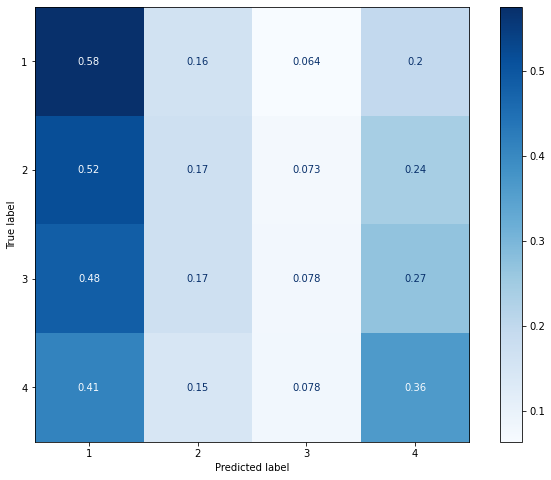

In [ ]:
#PREPARING CONFUSSION MATRIX
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

# Plot confusion matrix
classifier = model_rfc
class_names = y_test.unique().sort()
plot_confusion_matrix(classifier, X_test, y_test,
                      display_labels=class_names, cmap=plt.cm.Blues, normalize='true')
plt.grid(False)
#plt.title('Random Forest Cls Baseline)
fig = plt.gcf()
fig.set_size_inches(11,8)
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)


0.37240384615384614

In [ ]:
target_names = ['class 1', 'class 2','class 3', 'class 4']
classification_report(y_test, y_pred,target_names=target_names)

'              precision    recall  f1-score   support\n\n     class 1       0.45      0.58      0.51     12512\n     class 2       0.21      0.16      0.18      6600\n     class 3       0.14      0.08      0.11      3817\n     class 4       0.37      0.35      0.36      8271\n\n    accuracy                           0.37     31200\n   macro avg       0.29      0.29      0.29     31200\nweighted avg       0.34      0.37      0.35     31200\n'

# XGBOOST (FINAL MODEL)

In [ ]:
import xgboost as xgb

classifier = xgb.XGBClassifier(random_state=42)
#parameter information: (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)
#Copied from Kaggle (https://www.kaggle.com/phunter/xgboost-with-gridsearchcv)
#brute force scan for all parameters, here are the tricks
#usually max_depth is 6,7,8
#learning rate is around 0.05, but small changes may make big diff
#tuning min_child_weight subsample colsample_bytree can have 
#much fun of fighting against overfit 
#n_estimators is how many round of boosting
#finally, ensemble xgboost with multiple seeds may reduce variance
param_grid = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softmax'],
              'num_class': [4],
              #'learning_rate': [0.3], #so called `eta` value
              #'max_depth': [6],
              #'min_child_weight': [10], #Higher values minimize overfitting, default = 1
              #'silent': [0],
              #'subsample': [0.8], #Lower values (more conservative) prevents overfitting but too small values lead to under-fitting.
                                  #Typical values: 0.5-1
              #'colsample_bytree': [0.7],
              #'n_estimators': [500], #number of trees, change it to 1000 for better results
              #'missing':[-999],
              #'seed': [1337]
              }

xgb_grid = GridSearchCV(estimator=classifier, param_grid=param_grid, cv= 5,verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'num_class': [4], 'objective': ['multi:softmax']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None,

In [ ]:
model_xgb = xgb_grid.best_estimator_  # Sklearn automatically retrains the model on the whole 
                                      # training set following cross-validation using the best hyperparameters
#pred_prob = model_xgb.predict_proba(X_test)
xgb_grid.best_params_

{'num_class': 4, 'objective': 'multi:softmax'}

In [ ]:
y_pred = model_xgb.predict(X_test)
y_pred_proba = model_xgb.predict_proba(X_test)


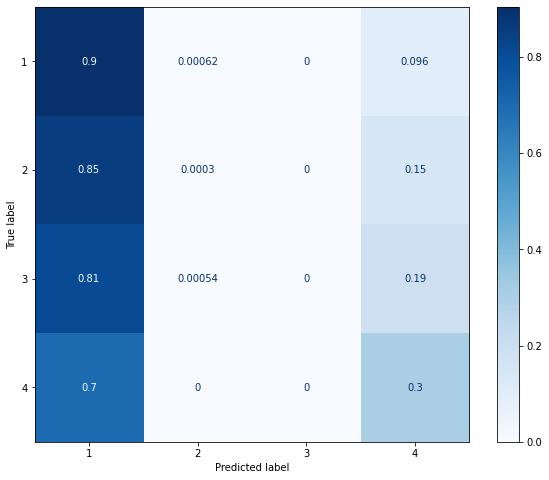

In [ ]:
#PREPARING CONFUSSION MATRIX
# Plot confusion matrix
class_names = y_test.unique().sort()
plot_confusion_matrix(model_xgb, X_test, y_test,
                      display_labels=class_names, cmap=plt.cm.Blues, normalize='true')
plt.grid(False)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [ ]:
accuracy_score(y_test, y_pred)

0.4555768089176176

In [ ]:
target_names = ['class 1', 'class 2','class 3', 'class 4']
print(classification_report(y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.46      0.90      0.61      6454
     class 2       0.17      0.00      0.00      3338
     class 3       0.00      0.00      0.00      1835
     class 4       0.42      0.30      0.35      3534

    accuracy                           0.46     15161
   macro avg       0.26      0.30      0.24     15161
weighted avg       0.33      0.46      0.34     15161



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



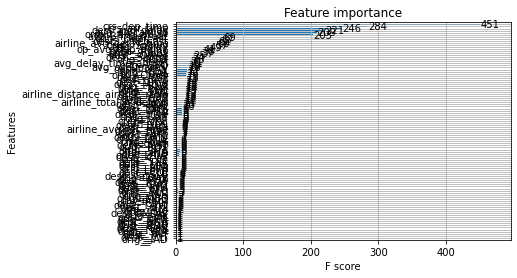

In [ ]:
xgb.plot_importance(model_xgb)
plt.rcParams['figure.figsize'] = [15, 15]
plt.show()
#model_xgb.coef_

# GENERATION OF DELAYS FROM CLASSES (FLOAT GENERATION FROM BINS AND MODEL CLASS PROBABILITIES)





In [ ]:
# FINAL DELAYS (FLOAT GENERATION FROM PROBABILITYS) 
#y_pred_proba = model_xgb.predict_proba(X_test)

#Average delay from range of each target class bin
bin1_avg = 5
bin2_avg = 15
bin3_avg = 25
bin4_avg = 30
y_final =[]

for index in range(len(y_pred_proba)):
  
  y_final.append(bin1_avg*y_pred_proba[index,0]+ bin2_avg*y_pred_proba[index,1] + bin3_avg*y_pred_proba[index,2] + bin4_avg*y_pred_proba[index,3])

#y_final

In [ ]:
#submission_File = pd.concat([submission_File, y_final], axis=1)

In [ ]:
#submission_File.to_csv('submission.csv',index=False)